In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Layer
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import matplotlib.pyplot as plt 
import math as mt

In [2]:
loss_tracker = keras.metrics.Mean(name="loss")

class Function(keras.Model):
    def train_step(self, data):
        batch_size = 10
        x = tf.random.uniform((batch_size,), minval=-1, maxval=1)
        eq = 3*tf.math.sin(mt.pi*x)

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            loss = keras.losses.mean_squared_error(y_pred,eq)

        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        loss_tracker.update_state(loss)

        return {"loss": loss_tracker.result()}

In [3]:
class SinTransform(tf.keras.layers.Layer):
    def __init__(self, num_outputs):
        super(SinTransform,self).__init__()
        self.num_outputs = num_outputs

        self.freq = tf.range(1., self.num_outputs + 1) # Aquí se definen las frecuencias para la función seno
        # Se crea un tensor que va desde 1 hasta el último valor numérico necesario para acompletar el 
        # número de salidas que se tiene en la función. 
        self.kernel = self.add_weight("kernel",
                                shape=[self.num_outputs])
        # En esta parte se crearon los valores para los coefficientes que serán entrenables y calculables 
        # para la función que se desea modelar. En este caso, corresponde cada uno de estos valores a los 
        # valores de los pesos. 

    def call(self, inputs):
        # Esta primer parte es para evitar problemas con la forma de las entradas y corregir si es necesario
        inputs = tf.convert_to_tensor(inputs)
        if (inputs.shape == ()):
            inputs=(inputs,)
        elif (len(inputs.shape)==1):
            inputs=tf.expand_dims(inputs, axis=1)
            
        # La función calcula una serie (sum_i=1^N a_i*sin(w_i*x))
        batch = tf.shape(inputs)[0]
        self.freq_b = tf.ones([batch,1])*self.freq # Crea un tensor cuyos elementos son 1's y multiplica cada uno
        # por los valores de las frecuencias.
        args = self.freq_b * inputs # Aquí se valcula el valor de las frecuencias (w_i*x)
        modes = tf.math.sin(args) # Se calcula los valores de sin(w_i*x)
        return tf.tensordot(modes,self.kernel,1)  # Se crea la serie de senos

In [4]:
inputs = keras.Input(shape=(1,))
x = SinTransform(5)(inputs)

model = Function(inputs=inputs,outputs=x)
model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Model: "function"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 sin_transform (SinTransform  (None,)                  5         
 )                                                               
                                                                 
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(optimizer=Adam(learning_rate=0.001), metrics=['loss'])

x=tf.linspace(-1,1,100)
history = model.fit(x,epochs=25,verbose=1)

Epoch 1/25
4/4 [==============================] - 0s 884us/step - loss: 0.2162
Epoch 2/25
4/4 [==============================] - 0s 1ms/step - loss: 0.2150
Epoch 3/25
4/4 [==============================] - 0s 1ms/step - loss: 0.2137
Epoch 4/25
4/4 [==============================] - 0s 956us/step - loss: 0.2124
Epoch 5/25
4/4 [==============================] - 0s 873us/step - loss: 0.2113
Epoch 6/25
4/4 [==============================] - 0s 929us/step - loss: 0.2101
Epoch 7/25
4/4 [==============================] - 0s 1ms/step - loss: 0.2089
Epoch 8/25
4/4 [==============================] - 0s 921us/step - loss: 0.2077
Epoch 9/25
4/4 [==============================] - 0s 914us/step - loss: 0.2065
Epoch 10/25
4/4 [==============================] - 0s 884us/step - loss: 0.2054
Epoch 11/25
4/4 [==============================] - 0s 960us/step - loss: 0.2043
Epoch 12/25
4/4 [==============================] - 0s 914us/step - loss: 0.2032
Epoch 13/25
4/4 [==============================] - 0s 8

4/4 [==============================] - 0s 871us/step


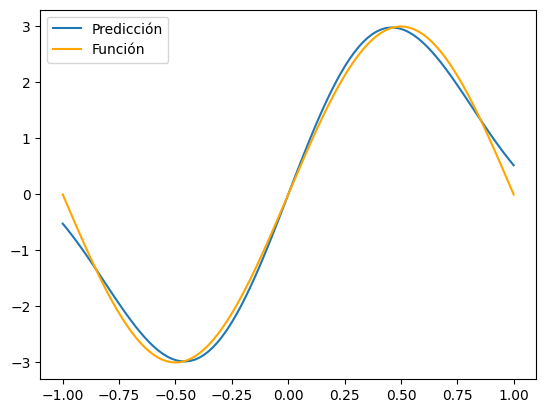

In [13]:
x_testv = tf.linspace(-1,1,100)
a=model.predict(x_testv)

plt.plot(x_testv,a, label = "Predicción")
plt.plot(x_testv, 3*tf.math.sin(mt.pi*x), label = "Función", color = "orange")
plt.legend()
plt.show()